# Finding topics in United Nations General Assembly debates

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import NMF

Let's start this off by loading the data and taking a look at it. We have the text of each debate speech, the year and session it occurred in, and the country that gave it. There are over 7500 speeches in total, spanning the the period from 1970 to 2015. 

In [2]:
data = pd.read_csv('un-general-debates.csv')
data.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


There are a few more speeches given in more recent years.

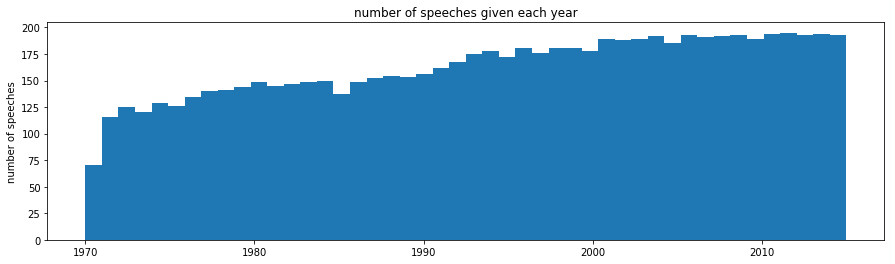

In [16]:
plt.figure(figsize=(15,4))
plt.hist(data.year, bins=len(data.year.unique()))
plt.ylabel('number of speeches')
plt.title('number of speeches given each year')
plt.show()

A first cut at topics, using bag-of-words and NMF. I'm excluding the basic English "stop words" from the NLTK library. These are words like "the", "of", etc. that don't add meaning to the speech.

In [6]:
stops = set(nltk.corpus.stopwords.words('english'))
bow = CountVectorizer(stop_words=stops)
bag = bow.fit_transform(data.text)

In [7]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(bag)
H = nmf.components_

Let's look at some of the top words in each topic:

In [8]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-20:]

array([['also', 'one', 'problems', 'assembly', 'nations', 'community',
        'government', 'us', 'new', 'country', 'people', 'south', 'must',
        'development', 'developing', 'africa', 'international',
        'economic', 'world', 'countries'],
       ['nuclear', 'assembly', 'council', 'organization', 'also', 'one',
        'security', 'global', 'rights', 'peace', 'general', 'us', 'new',
        'development', 'human', 'states', 'must', 'world', 'united',
        'nations'],
       ['would', 'relations', 'arab', 'struggle', 'independence',
        'security', 'military', 'soviet', 'war', 'nuclear',
        'international', 'republic', 'nations', 'countries', 'peoples',
        'world', 'peace', 'united', 'states', 'people'],
       ['organization', 'assembly', 'cooperation', 'support', 'human',
        'process', 'region', 'rights', 'country', 'political',
        'economic', 'also', 'council', 'general', 'efforts',
        'development', 'community', 'peace', 'security', 'intern

Hmmm. Some of these words aren't too meaningful in the context of the UN general assembly. Words like "nation" are going to be so common in these speeches as to be more or less meaningless in tying to distinguish between speech topics. So let's add to our list of stop words and run the NMF again.

In [17]:
stops2 = stops.union(set(['general', 'assembly',
        'government', 'country', 'people',
        'international', 'world', 'countries', 'also',
        'united', 'must', 'state', 'session',
        'nations', 'union'
        'policy', 'relations', 'nations', 'peoples',
        'region', 'political', 'country',
        'council']))

In [18]:
bow = CountVectorizer(stop_words=stops2)
bag = bow.fit_transform(data.text)

In [27]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(bag)
H = nmf.components_

Looking at the top words in each topic again:

In [28]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['force', 'east', 'efforts', 'foreign', 'problems', 'powers',
        'race', 'one', 'interests', 'important', 'situation', 'struggle',
        'independence', 'democratic', 'socialist', 'use', 'treaty',
        'forces', 'peaceful', 'non', 'economic', 'conference', 'europe',
        'new', 'operation', 'would', 'arms', 'policy', 'co',
        'disarmament', 'war', 'military', 'union', 'security', 'weapons',
        'peace', 'republic', 'soviet', 'nuclear', 'states'],
       ['action', 'well', 'financial', 'national', 'conflict', 'trade',
        'issues', 'continue', 'agenda', 'secretary', 'change', 'poverty',
        'climate', 'member', 'role', 'sustainable', 'reform',
        'important', 'work', 'regional', 'challenges', 'need', 'year',
        'organization', 'social', 'process', 'rights', 'developing',
        'support', 'states', 'cooperation', 'new', 'efforts', 'human',
        'community', 'economic', 'global', 'peace', 'security',
        'development'],
       ['self

Looks like we're getting some separation in the topics now. We might call them:
0) 

Text(0, 0.5, 'Topic Strength')

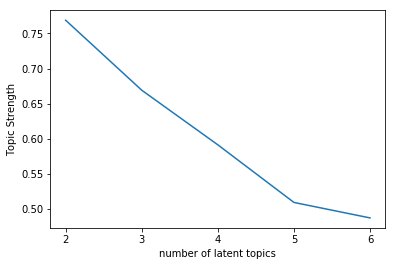

In [49]:
def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(bag)
    W = nmf.transform(bag)
    H = nmf.components_
    return (np.max(W, axis=1)/np.sum(W, axis=1)).mean()

topic_strength = [fit_nmf(i) for i in range(2,7)]
plt.plot(range(2,7), topic_strength)
plt.xticks(range(2,7))
plt.xlabel('number of latent topics')
plt.ylabel('Topic Strength')

Text(0, 0.5, 'Reconstruction Error')

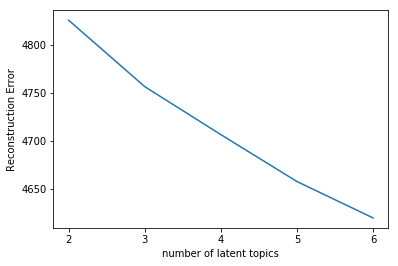

In [50]:
def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(bag)
    W = nmf.transform(bag)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(2,7)]
plt.plot(range(2,7), error)
plt.xticks(range(2,7))
plt.xlabel('number of latent topics')
plt.ylabel('Reconstruction Error')

NMF gives us an "amount" that each topic contributes to each speech. Let's go ahead and assign each speech it's highest valued topic.

In [29]:
top_topic = np.argmax(W, axis=1)
data["top_topic"] = top_topic

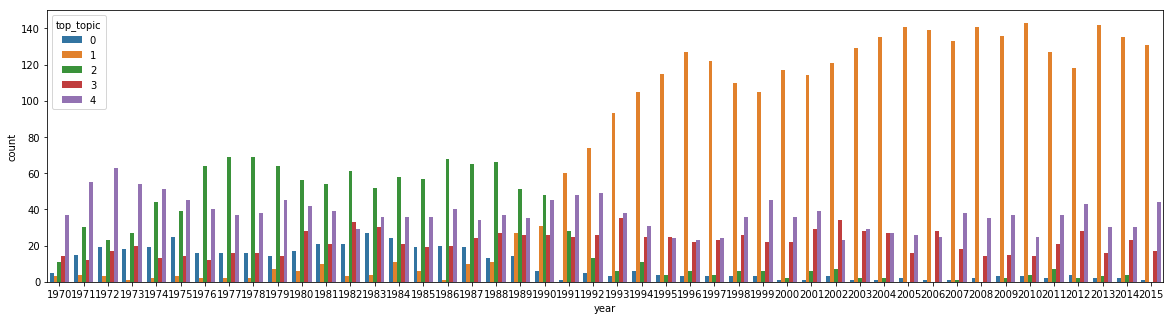

In [30]:
plt.figure(figsize=(20,5))
sns.countplot(x='year', hue='top_topic', data=data)

In [31]:
len(data.country.unique())

199

In [51]:
bow = CountVectorizer(stop_words=stops2, ngram_range=(1,2))
bag = bow.fit_transform(data.text)

In [52]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(bag)
H = nmf.components_

In [53]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['efforts', 'problems', 'powers', 'interests', 'race', 'one',
        'important', 'struggle', 'situation', 'independence', 'use',
        'socialist', 'democratic', 'treaty', 'forces', 'nuclear weapons',
        'peaceful', 'non', 'economic', 'conference', 'europe', 'new',
        'would', 'co operation', 'operation', 'arms', 'policy', 'co',
        'war', 'disarmament', 'soviet union', 'military', 'security',
        'union', 'weapons', 'republic', 'peace', 'soviet', 'nuclear',
        'states'],
       ['nuclear', 'small', 'financial', 'national', 'trade', 'issues',
        'secretary', 'agenda', 'continue', 'poverty', 'change', 'role',
        'member', 'climate', 'important', 'work', 'reform', 'regional',
        'sustainable', 'need', 'year', 'organization', 'challenges',
        'human rights', 'social', 'rights', 'process', 'developing',
        'support', 'states', 'cooperation', 'human', 'new', 'efforts',
        'community', 'economic', 'global', 'peace', 'security',


In [163]:
countries[np.argsort(W, axis=0)[-30:,:]].T

array([['ALB', 'UKR', 'VNM', 'UKR', 'ALB', 'BLR', 'BLR', 'CHN', 'ALB',
        'RUS', 'RUS', 'UKR', 'CHN', 'RUS', 'RUS', 'UKR', 'RUS', 'RUS',
        'ALB', 'RUS', 'ALB', 'RUS', 'BLR', 'RUS', 'RUS', 'RUS', 'RUS',
        'RUS', 'RUS', 'RUS'],
       ['JPN', 'BFA', 'JPN', 'AUS', 'KGZ', 'FJI', 'BRB', 'FJI', 'JPN',
        'TTO', 'CHN', 'IRL', 'GMB', 'BGD', 'COD', 'GMB', 'HRV', 'GUY',
        'JAM', 'PNG', 'AUS', 'FJI', 'CHN', 'MMR', 'GRC', 'TTO', 'KEN',
        'TTO', 'JAM', 'AUT'],
       ['LBR', 'KEN', 'TZA', 'ZMB', 'BFA', 'KEN', 'KEN', 'MOZ', 'MOZ',
        'KEN', 'MOZ', 'COD', 'MOZ', 'TZA', 'LSO', 'BDI', 'MOZ', 'GHA',
        'ETH', 'KEN', 'GMB', 'KEN', 'ZMB', 'TZA', 'SDN', 'ETH', 'UGA',
        'BWA', 'LSO', 'CUB'],
       ['SYR', 'SYR', 'EGY', 'SYR', 'JOR', 'IRQ', 'ISR', 'LBY', 'EGY',
        'EGY', 'JOR', 'ISR', 'EGY', 'LBN', 'JOR', 'YEM', 'EGY', 'EGY',
        'EGY', 'IRQ', 'ISR', 'JOR', 'JOR', 'SYR', 'IRQ', 'EGY', 'ISR',
        'JOR', 'ISR', 'EGY']], dtype=object)

In [164]:
np.argsort(W, axis=0)

array([[7506, 1045, 3753, 2414],
       [4038, 1310, 1517, 1086],
       [4043,  521, 1514, 6163],
       ...,
       [3176, 4973, 2501, 2486],
       [6824, 5203, 3147,  181],
       [2450, 4306, 3433, 2991]])

In [165]:
np.sort(W, axis=0)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [3.64098319, 1.82686436, 2.668842  , 3.19909418],
       [3.73447157, 2.00201022, 2.70503856, 3.4665379 ],
       [3.98997659, 2.05586423, 2.77473922, 4.32336785]])

In [166]:
W

array([[0.25308292, 0.60811003, 0.2862955 , 0.44344056],
       [0.24323456, 0.81796539, 0.19746887, 0.12057216],
       [0.07654987, 0.61067005, 1.27512114, 0.59372029],
       ...,
       [0.01144056, 0.5190242 , 0.19887596, 0.52684386],
       [0.15549587, 0.49925323, 0.        , 0.06664304],
       [0.        , 0.41519217, 0.0757424 , 0.64531225]])

In [167]:
len(W)/4

1876.75

In [168]:
top_countries = pd.DataFrame(countries[np.argsort(W, axis=0)[-1407:,:]])

In [169]:
topic0 = top_countries[0].groupby(by=top_countries[0]).count()

In [170]:
topic1 = top_countries[1].groupby(by=top_countries[1]).count()

In [171]:
topic2 = top_countries[2].groupby(by=top_countries[2]).count()

In [172]:
topic3 = top_countries[3].groupby(by=top_countries[3]).count()

In [173]:
topic0[topic0 > 15]

0
AFG    17
ALB    21
AUS    22
BEL    18
BGR    24
BLR    30
CHN    26
CSK    20
CUB    33
DDR    17
DEU    22
FRA    20
HUN    20
IND    20
IRL    21
IRN    23
IRQ    22
ITA    16
JPN    21
KHM    17
LBY    25
MEX    19
MNG    23
PAK    22
POL    24
PRK    25
ROU    20
RUS    30
SWE    17
UKR    29
USA    31
Name: 0, dtype: int64

In [174]:
topic1[topic1 > 15]

1
AUS    21
BGD    20
BRB    23
CAN    18
CHN    21
DEU    18
FJI    16
GUY    21
IND    17
IRL    24
JAM    28
JPN    23
KNA    20
LCA    19
LUX    16
MUS    19
NPL    20
PNG    23
SLB    21
SLV    16
TTO    27
Name: 1, dtype: int64

In [175]:
topic2[topic2 > 15]

2
AGO    16
BDI    22
BEN    20
BFA    18
BWA    18
CMR    18
COD    20
COG    20
DZA    17
ETH    21
GHA    21
GIN    19
IDN    19
KEN    21
LBR    16
MAR    16
MLI    22
MOZ    16
NER    19
NGA    23
RWA    21
SDN    20
SEN    21
SLE    19
SOM    18
TGO    19
TUN    16
TZA    23
UGA    21
ZMB    21
Name: 2, dtype: int64

In [176]:
topic3[topic3 > 15]

3
AFG     25
ARE     37
BHR     38
CYP     24
EGY     36
GRC     16
IRN     25
IRQ     42
ISR     43
JOR     39
KWT     42
LBN     42
LBY     37
MAR     32
MRT     19
OMN     28
PAK     19
PSE     18
QAT     29
SAU     30
SDN     32
SYR     44
TUN     32
TUR     21
YDYE    16
YEM     32
Name: 3, dtype: int64

In [178]:
top_topic = np.argmax(W, axis=1)
data["top_topic"] = top_topic

In [180]:
year_counts = data.groupby(by=['year', 'top_topic'])['session'].count().reset_index()

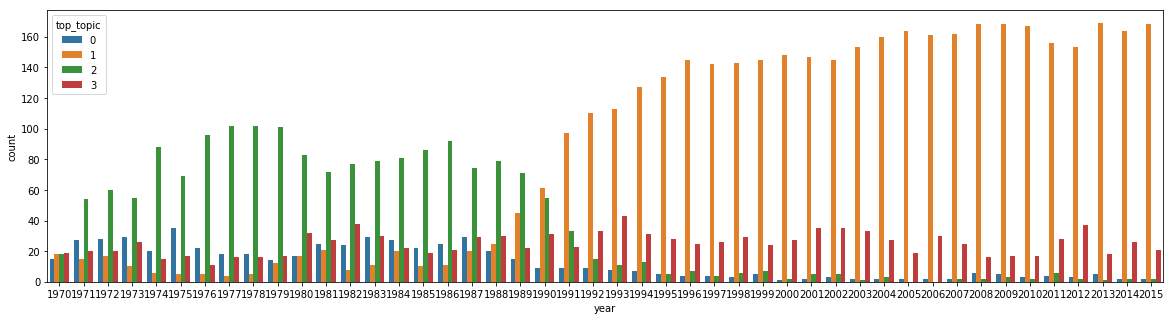

In [181]:
plt.figure(figsize=(20,5))
sns.countplot(x='year', hue='top_topic', data=data)

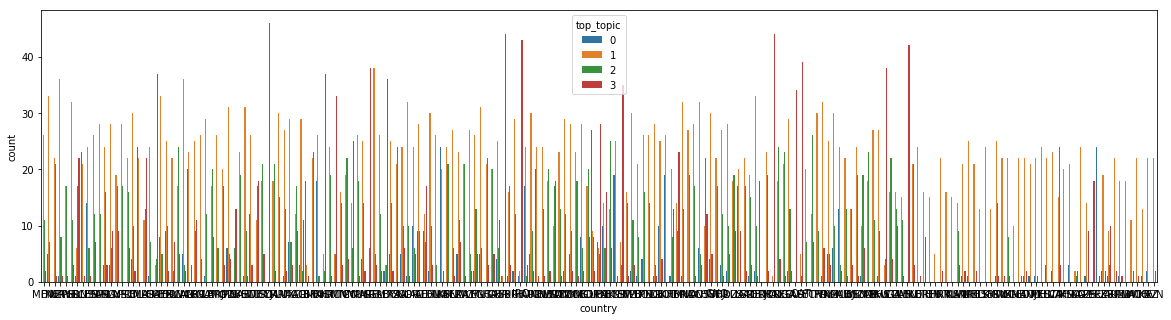

In [158]:
plt.figure(figsize=(20,5))
sns.countplot(x='country', hue='top_topic', data=data)

In [182]:
data[data.country=='USA']

,session,year,country,text,top_topic
124,44,1989,USA,﻿I am honoured to address the General Assembly...,0
161,25,1970,USA,1.\t It is my privilege to extend to you once ...,1
405,68,2013,USA,Each year we come together to \nreaffirm the f...,3
548,40,1985,USA,Let me start by joining the President of Brazi...,0
697,63,2008,USA,I am pleased to be here to \naddress the Gener...,1
818,46,1991,USA,﻿I am honoured to speak with you as you open t...,1
975,41,1986,USA,A short walk from this Hall is the delegates' ...,0
1243,57,2002,USA,﻿We meet one year and one day\nafter a terrori...,3
1308,30,1975,USA,"At the outset, let me say how pleased we are t...",0
1425,51,1996,USA,﻿Three years ago I had the honour\nof being th...,0


In [188]:
data.loc[161].text

"1.\t It is my privilege to extend to you once again the warm congratulations of the United States delegation on your election to the Presidency of the twenty-fifth session of the General Assembly. Your country has few peers in the contributions it has made to the work of this Organization. Your father was a leader in the League of Nations, and now, in this session of the General Assembly, you are adding a new chapter in the family tradition. In the United Nations community we have long known you as an able spokesman of your country, as a participant in the life of the United Nations from its very beginning and an authority on the Charter, as a leading scholar and practitioner in international law, and as one whose personal outlook is strongly humanitarian and imbued with hope and determination for a better future. We are indeed fortunate to have you to lead us in this session devoted to the strengthening and improvement of the United Nations.\n2.\tDuring this session we shall commemor